# 전통적 시계열 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다. 
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다. 
    * 예를 들면 
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.


![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경 준비

## (1) Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) Data Loading

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[(data['date']>= '2013-06-01') & (data['date']< '2015-07-01')].reset_index(drop = True)
data.head(10)

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
5,2013-06-06,28,112,881,71
6,2013-06-07,28,127,929,81
7,2013-06-08,28,105,925,78
8,2013-06-09,28,129,998,95
9,2013-06-10,28,103,710,74


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

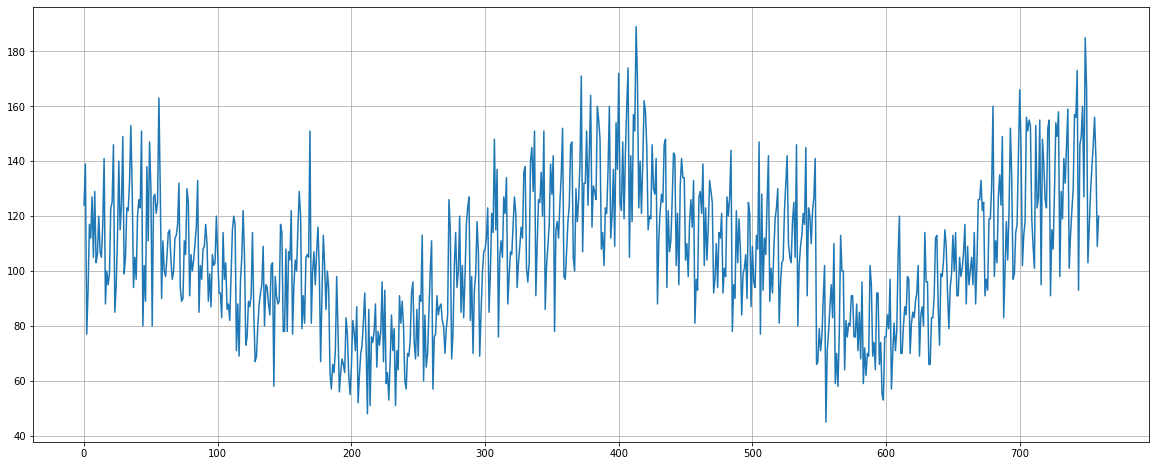

In [3]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

## (3) 함수 생성 

* 잔차분석

In [4]:
def residual_diag(residuals, lags = 20) :

    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

# 2.데이터 준비 

## (1) 시간정보 인덱스 만들기
* 날짜 타입으로 변환
* 날짜를 인덱스로
* freq 지정하기

### 1) 날짜 타입으로 변경하기

In [9]:
data['date'] = pd.to_datetime(data['date'])

### 2) 날짜를 인덱스로 변환하기

In [11]:
data['DT'] = data['date']
data.set_index('DT', inplace=True)
data.head()

,date,item,sales,tot_sales,comp_sales
DT,,,,,
2013-06-01,2013-06-01,28,124,1016,80
2013-06-02,2013-06-02,28,139,1019,93
2013-06-03,2013-06-03,28,77,676,65
2013-06-04,2013-06-04,28,93,764,80
2013-06-05,2013-06-05,28,117,818,80


### 3) 날짜단위 지정하기 : freq

* **분석 단위**를 어떻게 가져갈 것인가와 관련이 있습니다.
* 시계열 데이터를 **일정한 시간 간격**으로 만들어 줍니다.
* 인덱스 조회시, 마지막에 있는 **freq** 옵션

In [15]:
# 일단위
data.asfreq('D').head()
df = data.asfreq('D')
df.head()

,date,item,sales,tot_sales,comp_sales
DT,,,,,
2013-06-01,2013-06-01,28,124,1016,80
2013-06-02,2013-06-02,28,139,1019,93
2013-06-03,2013-06-03,28,77,676,65
2013-06-04,2013-06-04,28,93,764,80
2013-06-05,2013-06-05,28,117,818,80


## (2) y 만들기
2일후의 판매량을 예측해야 합니다.

In [16]:
df['y'] = df['sales'].shift(-1)
display(df.head())
display(df.tail())

,date,item,sales,tot_sales,comp_sales,y
DT,,,,,,
2013-06-01,2013-06-01,28,124,1016,80,139.0
2013-06-02,2013-06-02,28,139,1019,93,77.0
2013-06-03,2013-06-03,28,77,676,65,93.0
2013-06-04,2013-06-04,28,93,764,80,117.0
2013-06-05,2013-06-05,28,117,818,80,112.0


,date,item,sales,tot_sales,comp_sales,y
DT,,,,,,
2015-06-26,2015-06-26,28,146,1177,100,156.0
2015-06-27,2015-06-27,28,156,1171,118,141.0
2015-06-28,2015-06-28,28,141,1215,129,109.0
2015-06-29,2015-06-29,28,109,834,76,120.0
2015-06-30,2015-06-30,28,120,984,102,NaN


## (3) NaN 조치 
* y 생성으로 인해 NaN이 발생되었습니다. 어떻게 조치해야 할까요?

In [17]:
# 제일 마지막 행은 삭제
df.dropna(axis = 0, inplace = True)
df.tail()

,date,item,sales,tot_sales,comp_sales,y
DT,,,,,,
2015-06-25,2015-06-25,28,138,1062,120,146.0
2015-06-26,2015-06-26,28,146,1177,100,156.0
2015-06-27,2015-06-27,28,156,1171,118,141.0
2015-06-28,2015-06-28,28,141,1215,129,109.0
2015-06-29,2015-06-29,28,109,834,76,120.0


## (4) 가변수화

## (5) 데이터 분할

* Cross Validation : 데이터의 마지막 6개월을 6등분해서 교차 검증해 봅시다.
    * fold : 6
    * validation size : 1개월(30일)

### 1) x, y 나누기

In [18]:
target = 'y'

x = df.drop([target, 'date'], axis = 1)
y = df.loc[:, target]

### 2) 시계열 데이터 분할

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [19]:
from sklearn.model_selection import TimeSeriesSplit

In [20]:
# validation set size
val_size = 30
nfold = 3

tscv = TimeSeriesSplit(n_splits = nfold, test_size = val_size)

# 4.모델링 : Baseline Model

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import * 

## (1) Cross Validation

* for loop를 이용하여 Cross Validation을 수행하시오.
* 알고리즘은 LinearRegression을 이용하여 default로 사용

In [22]:
model = LinearRegression()

In [23]:
rmse, mae, mape = [],[],[]
residuals = []
pred = []

for train_index, val_index in tscv.split(x):

    # 인덱스로 데이터 분할
    x_train, y_train = x.iloc[train_index], y.iloc[train_index]
    x_val, y_val = x.iloc[val_index], y.iloc[val_index]

    # 학습
    model.fit(x_train, y_train)

    # 예측
    pr = model.predict(x_val)
    pred += list(pr)

    # 평가
    rmse.append(mean_squared_error(y_val, pr, squared = False))
    mae.append(mean_absolute_error(y_val, pr))
    mape.append(mean_absolute_percentage_error(y_val, pr))

    # 잔차 : 각 fold의 결과를 리스트로 변환하여 추가
    residuals += list(y_val - pr)

## (2) 예측 결과 평가

### 1) RMSE, MAE, MAPE

In [24]:
print('RMSE : ',round(np.mean(rmse),4))
print('MAE  : ',round(np.mean(mae),4))
print('MAPE : ',round(np.mean(mape),4))

RMSE :  24.6962
MAE  :  20.2368
MAPE :  0.1601


### 2) 그래프 비교

In [25]:
n = val_size * nfold
pred = pd.Series(pred, index = y[-n:].index)

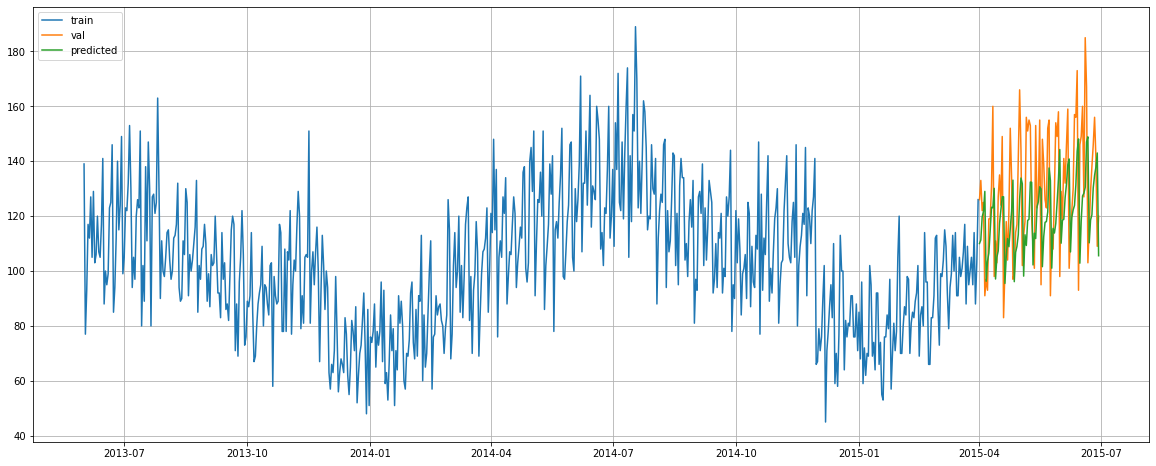

In [26]:
plt.figure(figsize = (20,8))
plt.plot(y[:-n], label = 'train')
plt.plot(y[-n:], label = 'val')
plt.plot(pred, label = 'predicted')

plt.legend()
plt.grid()
plt.show()

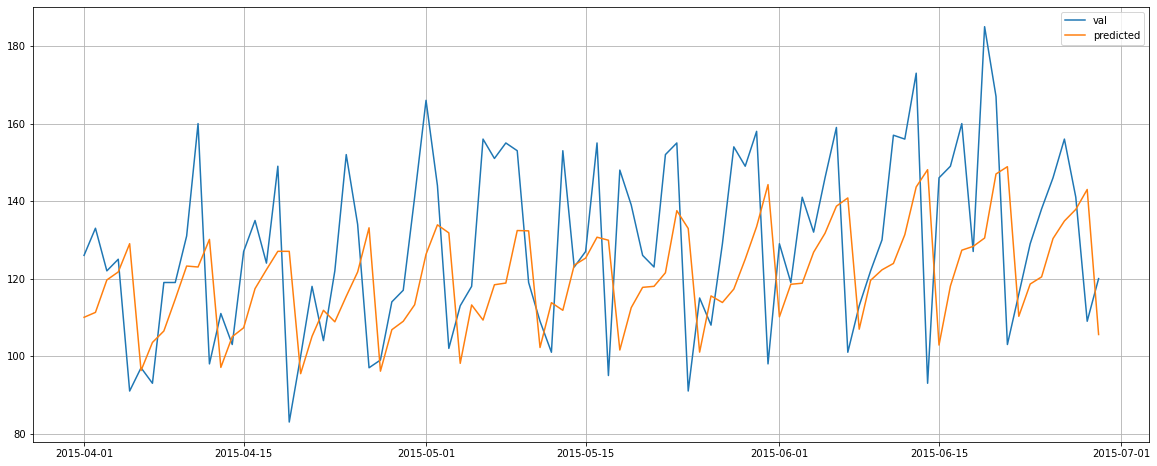

In [28]:
plt.figure(figsize = (20,8))
plt.plot(y[-n:], label = 'val')
plt.plot(pred, label = 'predicted')

plt.legend()
plt.grid()
plt.show()

# 5.평가 : 잔차분석

## (1) 시각화

* 잔차에 대해 라인차트, 히스토그램 등을 그려봅시다.

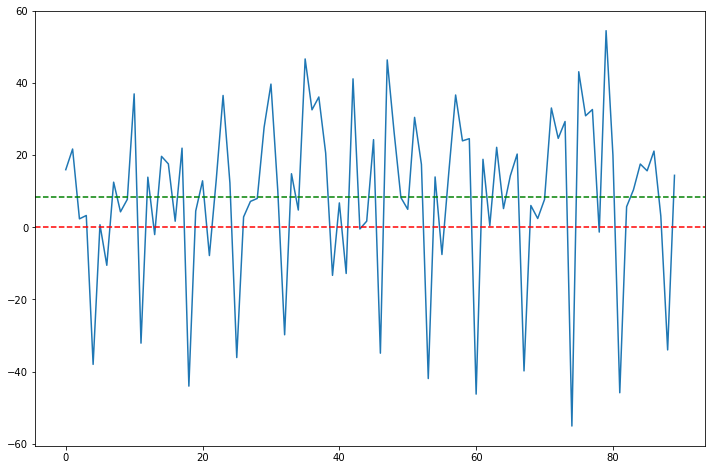

In [27]:
plt.figure(figsize = (12,8))
plt.plot(residuals)
plt.axhline(0, color = 'r', ls = '--')
plt.axhline(np.mean(residuals), color = 'g', ls = '--')
plt.show()

## (2) ACF, PACF

* acf, pacf 그림을 그려 자기 상관성 여부를 판단해 봅시다.

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

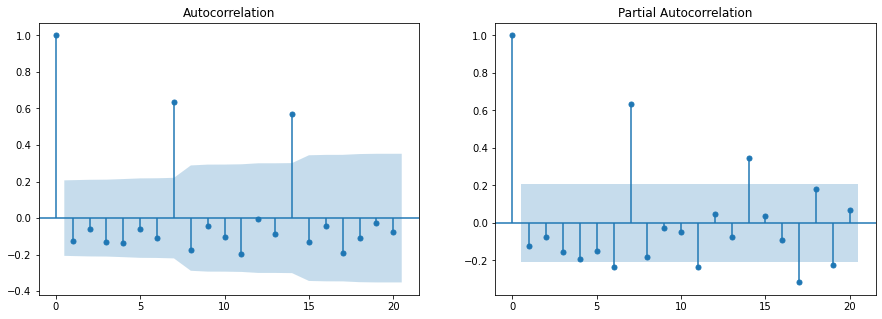

In [30]:
lags = 20

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_acf(residuals, lags = lags, ax = ax[0])
plot_pacf(residuals, lags = lags, ax = ax[1])
plt.show()

## (3) 검정

* 정규성 검정, 정상성 검정을 수행하고 판정해 봅시다.

In [31]:
from scipy import stats
import statsmodels.api as sm

* 정규성 검정 : Shapiro-Wilk 검정

In [32]:
stats.shapiro(residuals)[1]

0.00014496559742838144

* 정상성 검정 : ADF 검정

In [33]:
sm.tsa.stattools.adfuller(residuals)[1]

0.06254852345540264

# 6.모델링 : ARIMA

In [34]:
from sklearn.metrics import *

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00052
* 정상성 검정(< 0.05) :  0.67934
* 자기상관성 확인(ACF, PACF)


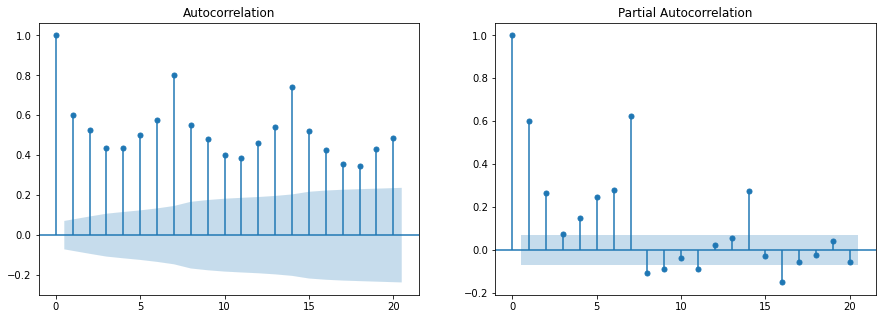

In [35]:
residual_diag(y, lags = 20)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.

In [36]:
train = y[:-30]
val = y[-30:]

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [38]:
model1 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit() # ARIMA

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0006
* 자기상관성 확인(ACF, PACF)


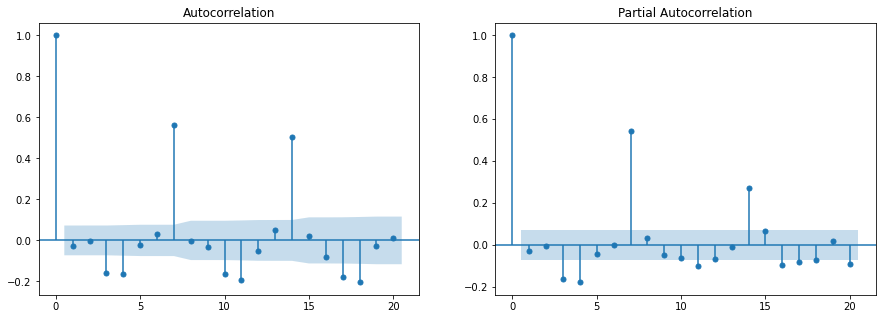

In [40]:
residuals = model1.resid  # y_train과 예측값 차이
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [41]:
print('model1 AIC :', model1.aic)

model1 AIC : 6279.816023439711


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [42]:
pred = model1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 19.430314178834617
MAPE: 0.15004726153916972


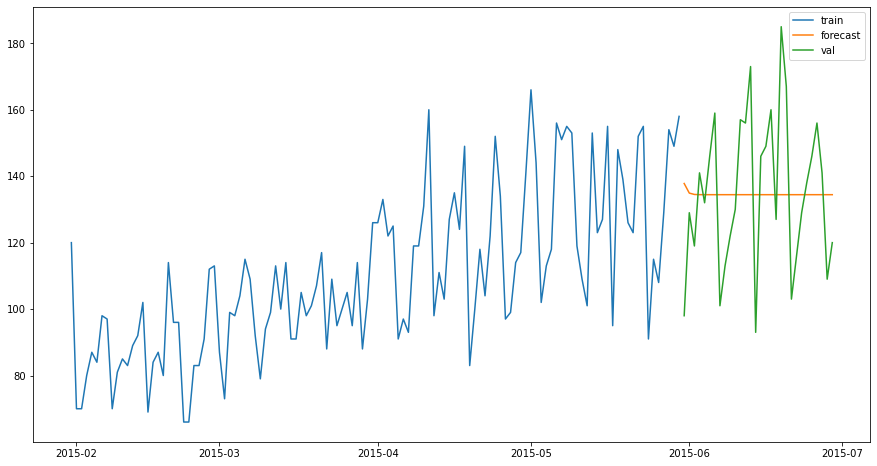

In [43]:
plt.figure(figsize=(15,8))
plt.plot(train[-120:], label='train')
plt.plot(pred, label = 'forecast')
plt.plot(val, label = 'val')
plt.legend()
plt.show()

## (3) 하이퍼파라미터 튜닝

### 1) 학습

In [45]:
from itertools import product

* 값의 범위 지정

In [46]:
# product 함수를 이용하여 값의 조합을 구성
p = [1,2,3,4]
q = [1,2,3,4]
d = [1,2]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4)]

In [48]:
# 
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 2, 1)
(2, 2, 2)
(2, 2, 3)
(2, 2, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 2, 1)
(3, 2, 2)
(3, 2, 3)
(3, 2, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 2, 1)
(4, 2, 2)
(4, 2, 3)
(4, 2, 4)


In [49]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
18,"(3, 1, 3)",14.035671,5993.733749


,"params(p,d,q)",mae,aic
27,"(4, 1, 4)",14.458549,5988.776939


In [50]:
model2_1 = sm.tsa.SARIMAX(y_train, order=(3,1,3)).fit()
model2_2 = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


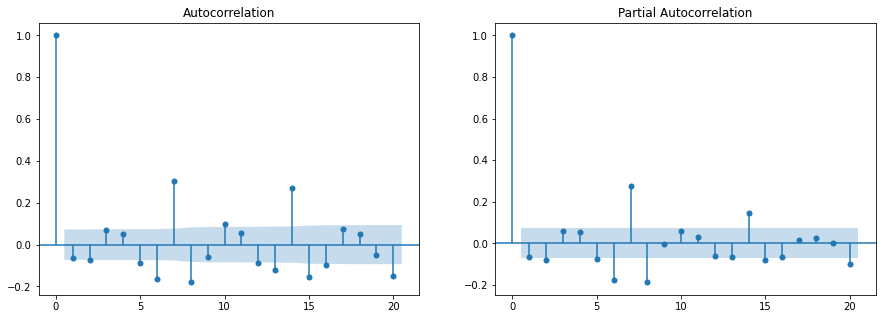

In [51]:
residuals = model2_1.resid
residual_diag(residuals) 

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


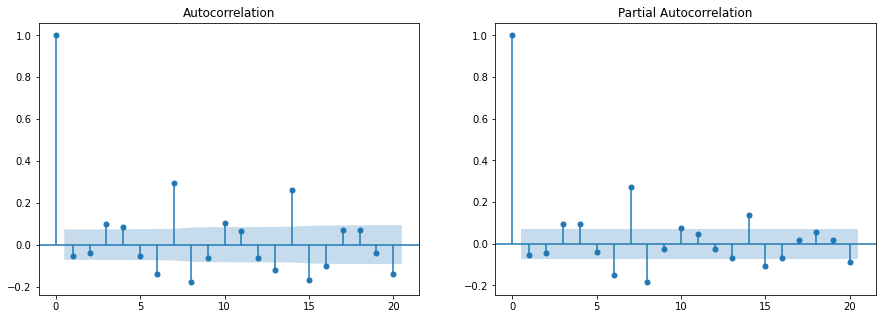

In [52]:
residuals = model2_2.resid
residual_diag(residuals) 

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [53]:
print('model2 AIC :', model2_1.aic)
print('model2 AIC :', model2_2.aic)

model2 AIC : 5993.733748965036
model2 AIC : 5988.776939336642


#### ③ Validation(그래프 비교)


In [56]:
p1 = model2_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, p1))
print('MAPE:', mean_absolute_percentage_error(y_val, p1))

MAE : 14.03567136621148
MAPE: 0.10719695944408775


In [60]:
p1 = model2_2.forecast(30)
print('MAE :', mean_absolute_error(y_val, p1))
print('MAPE:', mean_absolute_percentage_error(y_val, p1))

MAE : 14.45854931828953
MAPE: 0.1102505018126945


In [58]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

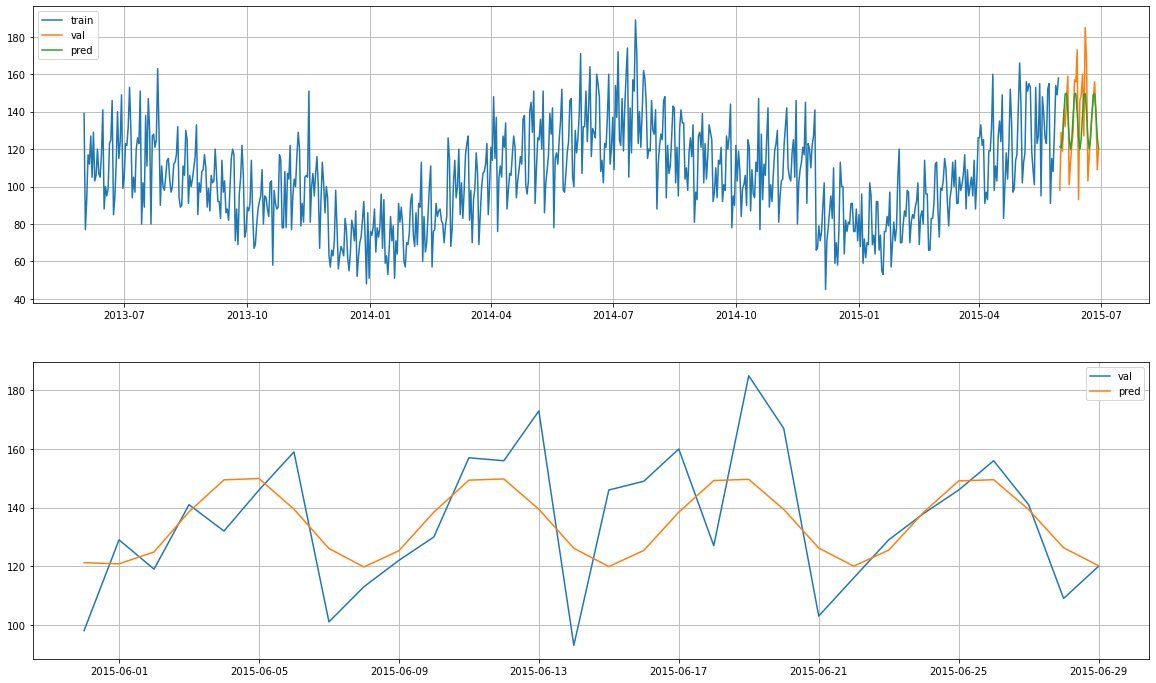

In [59]:
plot_model_result(y_train, y_val, p1)

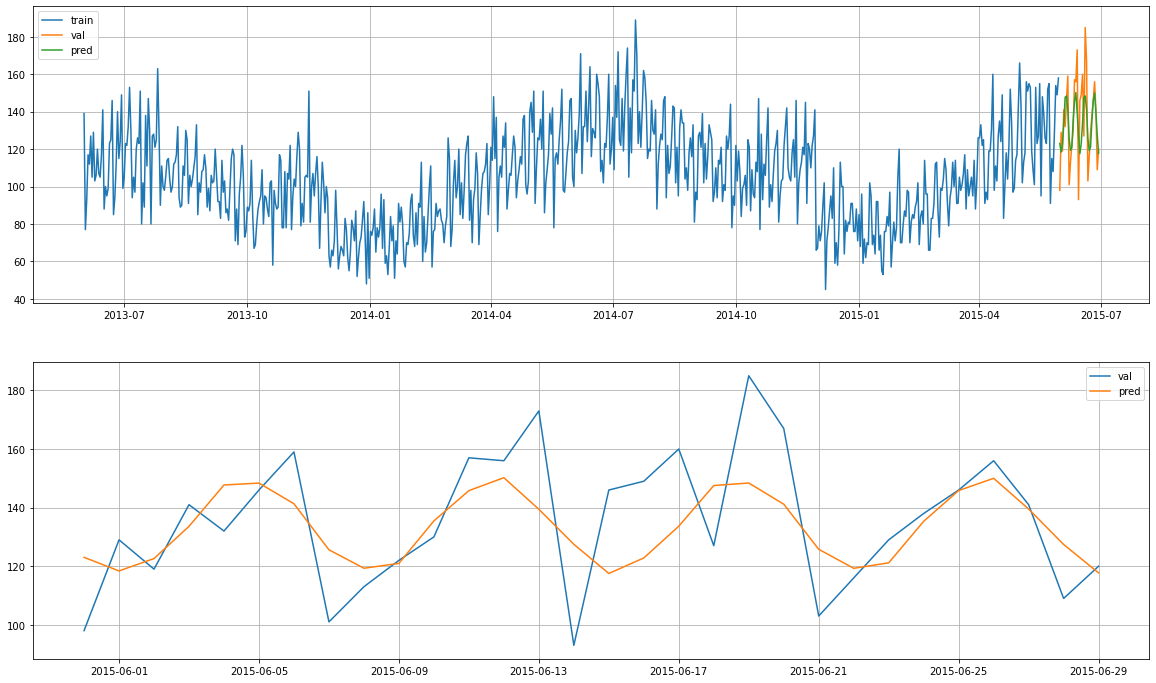

In [61]:
plot_model_result(y_train, y_val, p1)

## (4) Cross Validation

### 1) 학습

In [62]:
rmse, mae, mape, aic = [],[],[],[]
residuals = []
preds = []
p,d,q = 2,2,3

for train_index, val_index in tscv.split(x):

    # 인덱스로 데이터 분할
    train = y[train_index]
    val = y[val_index]

    # 학습
    model = sm.tsa.SARIMAX(train, order=(p,d,q)).fit()

    # 예측
    pred = model.forecast(val_size)
    preds += list(pred)

    # 잔차 저장
    residuals += list(model.resid)

    # 평가
    rmse.append(mean_squared_error(val, pred, squared = False))
    mae.append(mean_absolute_error(val, pred))
    mape.append(mean_absolute_percentage_error(val, pred))
    aic.append(model.aic)

In [63]:
print('RMSE : ',round(np.mean(rmse),4))
print('MAE  : ',round(np.mean(mae),4))
print('MAPE : ',round(np.mean(mape),4))

RMSE :  22.4573
MAE  :  18.7869
MAPE :  0.1607


### 2) 평가

#### ① 잔차진단

* residual_diag

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

#### ③ Validation

In [ ]:
n = nfold * val_size

In [ ]:
preds = pd.Series(preds, index = y[-n:].index)
print('MAE :', mean_absolute_error(y[-n:], preds))

plt.figure(figsize = (20,8))
plt.plot(y[-200:], label = 'train')
plt.plot(y[-n:], label = 'val')
plt.plot(preds, label = 'predicted')

plt.legend()
plt.grid()
plt.show()

# 7.모델링 : SARIMA

## (1) 모델링 : 초기모델

In [ ]:
train = y[:-30]
val = y[-30:]

### 1) 학습

In [ ]:
model1 = sm.tsa.SARIMAX(train, order=(2,2,3), seasonal_order = (1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

#### ② AIC

#### ③ Validation(그래프 비교)


## (2) 하이퍼파라미터 튜닝

### 1) 학습

In [ ]:
from itertools import product

### 2) 평가

#### ① 잔차진단

#### ② AIC

#### ③ Validation(그래프 비교)


## (3) Cross Validation

### 1) 학습

### 2) 평가1

#### ① 잔차진단

#### ② AIC

#### ③ Validation(그래프 비교)


# 8.모델링 : SARIMAX

## (1) 모델링

### 1) 학습

In [ ]:
val_size = 30
x_train, y_train = x[:-val_size], y[:-val_size]
x_val, y_val = x[-val_size:], y[-val_size:]

In [ ]:
x_train.shape, y_train.shape

### 2) 평가

#### ① 잔차진단

* residual_diag

#### ② AIC

#### ③ Validation (그래프비교)
SARIMAX 모델을 생성하고, 예측할 때는 exog=x_val 옵션이 들어가야 함.

In [ ]:
pred = model3_1.forecast(30,  exog=x_val)
mean_absolute_error(val, pred)

## (2) Cross Validation

### 1) 학습

### 2) 평가

#### ① 잔차진단

#### ② AIC

#### ③ Validation(그래프 비교)


-------